# Problem Set 3

#### Exercise 1
We have a very standard OLG model with 20 periods (= 20 overlapping generations at each point in time) where individuals choose optimal asset holdings (consumption as a state variable). The exercise very closely follows the lecture 6 and the **backward shooting algorithm** to determine life-time patterns. We will make use of the **Value function** and the **Envelope theorem**.

#### (a)
Follows exactly the lecture notes:
- rewrite the problem in terms of the value function, 
- take the FOC and 
- apply the envelope theorem

#### (b)
In order to arrive at the **Boundary Value Problem** (BVP) we substitute the BC into the EE (to arrive at a second order DE) and consider the boundary conditions. This is the problem to be solved via the backward shooting algorithm! The problem reads:

$$\left((1 + r_{t+i-1})a_{i,t} + (1-\tau)w_{i,t+i-1} - a_{i+1,t} \right)^{-\sigma} = \beta (1+r_{t+i})\left((1 + r_{t+i})a_{i+1,t} + (1-\tau)w_{i+1,t+i} - a_{i+2,t} \right)^{-\sigma}$$

#### (c)
We will now assume that interest rates are exogeneously given $r^* = 0.1$ and steady state wages are 1 (for all generations)! Solve the above equation numerically. There certainly exists already implemented shooting algorithms but here we will write our own method.

In [156]:
# We will define an OLG class to achieve this
import numpy as np
from scipy.optimize import fsolve

class OLG:
    """
    Defines an instance of a OLG model according to the equation above and the exogeneous parameters.
    Solves the BVP problem by backward shooting.
    """
    def __init__(self, r, τ, w, σ, β, I):
        self.r, self.τ, self.w, self.σ, self.β, self.I = r, τ, w, σ, β, I
        
    def EE(self, a2, a3, w1, w2):
        "Defines the second order DE"
        # Unpack params
        β, r, σ, τ = self.β, self.r, self.σ, self.τ
        γ1 = 1 / (β**(1 / σ) * (1 + r)**(1 / σ)) + 1 / (1 + r)
        γ2 = - (1 / (β**(1 / σ) * (1 + r)**((1 + σ) / σ)))
        γ3 = - ((1 - τ) / (1 + r))
        γ4 = (1 - τ) / (β**(1 / σ) * (1 + r)**((1 + σ) / σ))
        # Wage is not a constant!
        return γ1 * a2 + γ2 * a3 + γ3 * w1 + γ4 * w2
    
    def backward_shooting(self, init, conv):
        """
        Findes the solution to the EE s.t. the boundary conditions are satisfied; 
        init is the initial guess for the asset holdings in the last period, conv the convergence criterion
        """
        # We flip the asset vector in the end (this means, initially, the first entry is the last one - if you know what I mean)
        # Importantly, wage is zero during the last 5 periods!
        w_working = np.repeat(self.w, 15)
        w_pension = np.repeat(0, 5)
        wage = np.concatenate((w_pension, w_working))
        
        a1 = conv + 1
        while abs(a1) > conv:
            # Init asset vector
            a3 = 0
            a2 = init
            a = []
            a.append(a3)
            a.append(a2)
            for i in range(self.I - 2):
                a1 = self.EE(a2 = a2, a3 = a3, w1 = wage[i + 2], w2 = wage[i + 1])
                a.append(a1)
                a3 = a2
                a2 = a1
            init = init - 0.1 * a1
        return np.flip(a)

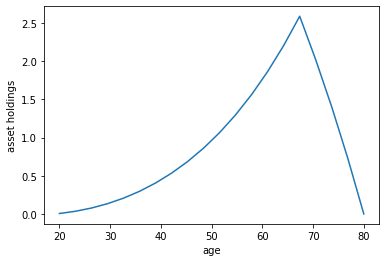

In [157]:
import matplotlib.pyplot as plt
%matplotlib inline

olg = OLG(r = 0.1, τ = 0, w = 1, σ = 2, β = 0.89, I = 20)
asset_holdings = olg.backward_shooting(init = 1, conv = 0.01)

fix, ax = plt.subplots()
ax.plot(np.linspace(20,80,20), asset_holdings)
ax.set_xlabel('age')
ax.set_ylabel('asset holdings')
plt.show()

In [158]:
def consumption(OLG, asset_holdings):
    "Consumption can be recovered from the BC"
    w_working = np.repeat(OLG.w, OLG.I - 5)
    w_pension = np.repeat(0, 5)
    wage = np.concatenate((w_working, w_pension))
        
    c = []
    for i in range(len(asset_holdings) - 1):
        c_new = (1 + OLG.r) * asset_holdings[i] + (1 - OLG.τ) * wage[i] - asset_holdings[i + 1]
        c.append(c_new)
    return c

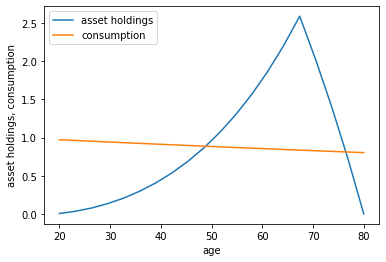

In [159]:
c = consumption(olg, asset_holdings)

fix, ax = plt.subplots()
ax.plot(np.linspace(20,80,20), asset_holdings, label = 'asset holdings')
ax.plot(np.linspace(20,80,19), c, label = 'consumption')
ax.set_xlabel('age')
ax.set_ylabel('asset holdings, consumption')
ax.legend()
plt.show()

#### (d)
Endogenize interest rate

In [179]:
# We will define an OLG_end_int class to achieve this
import numpy as np
from scipy.optimize import fsolve

class OLG_end_int:
    """
    Defines an instance of a OLG model according to the equation above and the exogeneous parameters.
    Solves the BVP problem by backward shooting. But now, we endogenize interest rates!
    """
    def __init__(self, τ, w, σ, β, I, α):
        self.τ, self.w, self.σ, self.β, self.I, self.α = τ, w, σ, β, I, α
        
    def EE(self, a2, a3, w1, w2, r):
        "Defines the second order DE"
        # Unpack params
        β, σ, τ = self.β, self.σ, self.τ
        γ1 = 1 / (β**(1 / σ) * (1 + r)**(1 / σ)) + 1 / (1 + r)
        γ2 = - (1 / (β**(1 / σ) * (1 + r)**((1 + σ) / σ)))
        γ3 = - ((1 - τ) / (1 + r))
        γ4 = (1 - τ) / (β**(1 / σ) * (1 + r)**((1 + σ) / σ))
        # Wage is not a constant!
        return γ1 * a2 + γ2 * a3 + γ3 * w1 + γ4 * w2
    
    def interest(self, K):
        "Defines interest rate as the marginal product of capital"
        return self.α * (K**(self.α - 1)) * (15**(1 - self.α))
    
    def backward_shooting(self, init_a2, init_K, conv):
        """
        Findes the solution to the EE s.t. the boundary conditions are satisfied; 
        init is the initial guess for the asset holdings in the last period, conv the convergence criterion
        """
        # We flip the asset vector in the end (this means, initially, the first entry is the last one - if you know what I mean)
        # Importantly, wage is zero during the last 5 periods!
        w_working = np.repeat(self.w, 15)
        w_pension = np.repeat(0, 5)
        wage = np.concatenate((w_pension, w_working))
        
        K = init_K
        outer_check = conv + 1
        while outer_check > conv:
            # Compute endogeneous interest rate
            r = self.interest(K)
            a1 = conv + 1
            while abs(a1) > conv:
                # Init asset vector
                a3 = 0
                a2 = init_a2
                a = []
                a.append(a3)
                a.append(a2)
                # Compute assets recursively with EE
                for i in range(self.I - 2):
                    a1 = self.EE(a2 = a2, a3 = a3, w1 = wage[i + 2], w2 = wage[i + 1], r = r)
                    a.append(a1)
                    a3 = a2
                    a2 = a1
                init_a2 = init_a2 - 0.1 * a1
            # Steady-state condition: capital stock = total asset holdings    
            outer_check = abs(K - sum(a))    
            K = K - 0.1*(K - sum(a))
        return {'assets' : np.flip(a), 'interest' : r}

In [180]:
def consumption(OLG, asset_holdings):
    "Consumption can be recovered from the BC"
    w_working = np.repeat(OLG.w, OLG.I - 5)
    w_pension = np.repeat(0, 5)
    wage = np.concatenate((w_working, w_pension))
    r = OLG.backward_shooting(init_a2 = 1, init_K = 10, conv = 0.01)['interest']
        
    c = []
    for i in range(len(asset_holdings) - 1):
        c_new = (1 + r) * asset_holdings[i] + (1 - OLG.τ) * wage[i] - asset_holdings[i + 1]
        c.append(c_new)
    return c

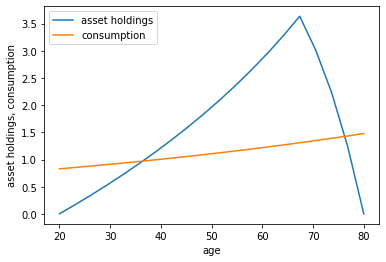

In [181]:
olg = OLG_end_int(τ = 0, w = 1, σ = 2, β = 0.89, I = 20, α = 0.33)
asset_holdings = olg.backward_shooting(init_a2 = 1, init_K = 10, conv = 0.01)['assets']
c = consumption(olg, asset_holdings)

fix, ax = plt.subplots()
ax.plot(np.linspace(20,80,20), asset_holdings, label = 'asset holdings')
ax.plot(np.linspace(20,80,19), c, label = 'consumption')
ax.set_xlabel('age')
ax.set_ylabel('asset holdings, consumption')
ax.legend()
plt.show()